# Preliminary of hack-phenomx env and inital development tasks
* Compare PhenomXHM modes to NR data
  * Load NR data
  * Generate model waveform 
  * Compare by plotting FD waveforms (different modes)
* Apply test modifation to PhenomXHM ringdown frequency and compare to NR and default PhenomXHM

In [1]:
# Setup the notebook's environment
import lalsimulation as lalsim
import lal
import numpy as np
from matplotlib.pyplot import *
from positive import *
from nrutils import lalphenom
from positive.units import *
from nrutils import scsearch,gwylm

(positive)>> Applying custom matplotlib settings.


In [2]:
# Let the user know where lalsimulation lives
alert('We are getting our LALSimulation from:\n%s'%green(lalsim.__path__[0]))

(notebook)>> We are getting our LALSimulation from:
/Users/book/opt/anaconda2/envs/hack-phenomx/lib/python2.7/site-packages/lalsimulation


## Load reference NR data

In [3]:
# Find a catalog entry of interest using a keyword search
a = scsearch(keyword='q8a08t150',verbose=True)[0]

(scsearch)>> Found keyword (=q8a08t150) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
(scsearch)>> ## Found 2 possibly degenerate simulations:
(scsearch)>> [0001][hogshead] q8precessing: 1chi0.80-p-q8.00	(q8a08t150dP2_T_120_480)
(scsearch)>> [0002][hogshead] q8precessing: 1chi0.80-p-q8.00	(q8a08t150dP2_T_96_360)



In [7]:
# # Load the realted NR waveform
# y = {}
# lpm_space = [ (2,2),(2,1),(2,0)] # ,(3,3),(3,2),(4,4)
# lm_space = list(set(lpm_space + [ (l,-m) for l,m in lpm_space  ]))
# y['raw'] = gwylm(a,lm=lm_space,dt=0.5,clean=True,verbose=False,pad=2000, enforce_m_relative_sign_convention=not False)

In [ ]:
# # Generate waveform in L-frame (this rotates all multipoles and vector metadata)
# # y['j'] = y['raw'].__calc_j_of_t_frame__()
# y['j'] = y['raw'].__calc_initial_j_frame__().__symmetrize__()

In [ ]:
# # Generate waveform in L-frame (this rotates all multipoles and vector metadata)
# y['lal'] = y['j'].__calc_initial_l_frame__()

In [ ]:
# y['cp'] = y['j'].__calc_coprecessing_frame__(transform_domain='td',kind='psi4')

## Compute model waveform for comparison

In [12]:

def PolarizationsFD(approximant, modeList, threshold, m1, m2, s1, s2, delta_f, phiRef,nu0 = 0):
      
    lalparams = lal.CreateDict()
    
    #
    output_modes = {}
    
    #
    ModeArray = lalsim.SimInspiralCreateModeArray()
    for mode in modeList:
        
        #
        l,m = mode
        
        #
        lalsim.SimInspiralModeArrayActivateMode(ModeArray, l,m)
        lalsim.SimInspiralWaveformParamsInsertModeArray(lalparams, ModeArray)

        #
        lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(lalparams, threshold)
        lalsim.SimInspiralWaveformParamsInsertPhenomXCPFlag( lalparams, 1 )
        lalsim.SimInspiralWaveformParamsInsertPhenomXCPfRing22Deviation( lalparams, nu0 )

        #
        f_min       = 10.0
        f_max       = 2048.0
        Omega       = 0.
        inclination = 1.3232 # Chosen so that it doesn't correxpond to a spherical hamonic root
        distance_Mpc= 100.0
        distance    = distance_Mpc*1.0e6*lal.PC_SI

        Hp, Hc = lalsim.SimInspiralChooseFDWaveform(m1=lal.MSUN_SI*m1,
                                                m2=lal.MSUN_SI*m2, 
                                                S1x=s1[0], S1y=s1[1], S1z=s1[2],
                                                S2x=s2[0], S2y=s2[1], S2z=s2[2],
                                                distance=distance, 
                                                inclination=inclination, 
                                                LALpars=lalparams,
                                                phiRef=phiRef, 
                                                f_ref=f_min,
                                                deltaF=delta_f,
                                                f_min=f_min,
                                                f_max=f_max,
                                                longAscNodes=Omega,
                                                eccentricity=0.0,
                                                meanPerAno=0.0,
                                                approximant=approximant) 

        #
        freqs = np.arange(len(Hp.data.data)) * delta_f

        #
        s = -2
        spehrical_harmonic = sYlm(s,l,m,inclination,0)
        hp = Hp.data.data / spehrical_harmonic
        hc = Hc.data.data / spehrical_harmonic
        
        #
        Mtot = m1+m2
        hp = codehf(hp,Mtot,distance_Mpc)
        hc = codehf(hc,Mtot,distance_Mpc)
        f  = codef(freqs,Mtot) 
        
        #
        output_modes[l,m] = (hp,hc,f)
    
    #
    return output_modes

In [13]:

l,m = 2,2
modeList = [ [l,m] ]
threshold = 0
M = 100

# m1 = y['lal'].m1 * M / ( y['lal'].m1 + y['lal'].m2 )
# m2 = y['lal'].m2 * M / ( y['lal'].m1 + y['lal'].m2 )
# s1 = [0,0,y['lal'].X1[-1]] # Only use z-component becuase PhenomXHM (no precession) is the approx
# s2 = [0,0,y['lal'].X2[-1]] # Only use z-component becuase PhenomXHM (no precession) is the approx

m1 = a.m1 * M / ( a.m1 + a.m2 )
m2 = a.m2 * M / ( a.m1 + a.m2 )
s1 = [0,0,a.X1[-1]] # Only use z-component becuase PhenomXHM (no precession) is the approx
s2 = [0,0,a.X2[-1]] # Only use z-component becuase PhenomXHM (no precession) is the approx

delta_f = 0.125
phiRef = 3.4332

#
moments_dict = PolarizationsFD(lalsim.IMRPhenomXHM, modeList, threshold, m1, m2, s1, s2, delta_f, phiRef)

#
hp,hc,f = moments_dict[l,m]
h = hp + 1j*hc

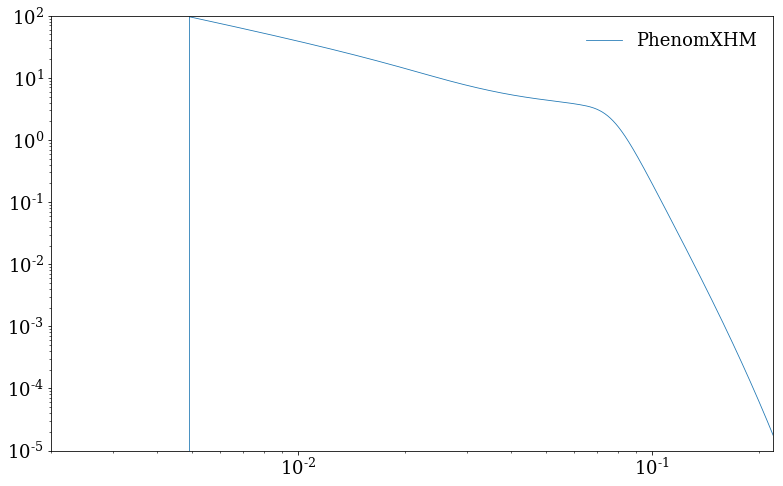

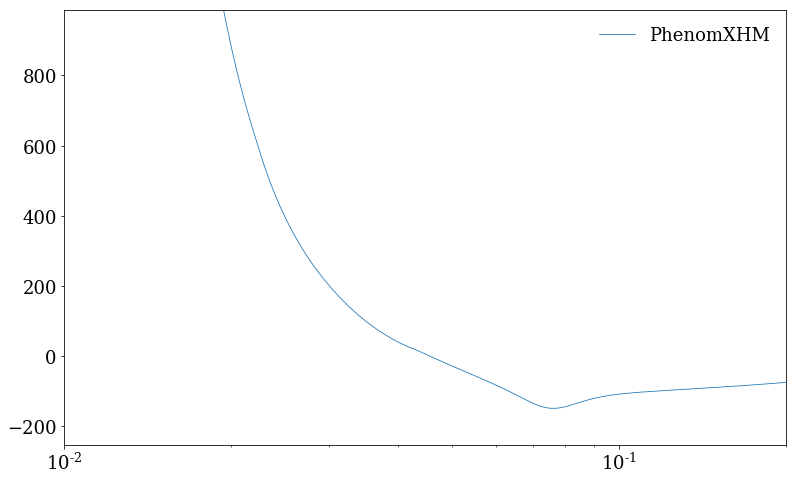

In [14]:
# Compare single mode generated above to NR
figure( figsize=2*figaspect(0.618) )

# plot( y['lal'].f,y['cp'][l,m]['strain'].fd_amp,label='nr-cp-frame' )
# # plot( y['lal'].f,y['lal'][l,m]['strain'].fd_amp,label='nr-lal-frame' )

plot( f, abs(h),label='PhenomXHM' )
xscale('log')
yscale('log')
xlim(0.002*m/2,0.22)
ylim(1e-5,1e2)
legend(loc=1)

f0,f1 = 0.02,0.1
def calc_dphi(f,h):
    phi = np.unwrap(np.angle(h))
    dphi = spline_diff(f,phi)
    dphi -= np.mean(dphi[ (f>f0) & (f<f1) ])
    return dphi

# Compare single mode generated above to NR
figure( figsize=2*figaspect(0.618) )

# plot( y['lal'].f,calc_dphi(y['lal'].f,y['cp'][l,m]['strain'].fd_y),label='nr-cp-frame' )
# # plot( y['lal'].f,calc_dphi(y['lal'].f,y['lal'][l,m]['strain'].fd_y),label='nr-lal-frame' )

plot( f, calc_dphi(f,h),label='PhenomXHM' )
xscale('log')
# yscale('log')
xlim(0.01,0.2)
mask = (f>f0) & (f<f1)
ylim( lim(calc_dphi(f,h)[mask],dilate=.1) )
# ylim(1e-5,1e2)
legend(loc=1)


In [ ]:
# frd = 0.079572
frd = 0.074572

In [15]:
print 0.079572-0.074572

0.005


In [ ]:
# frd = 0.056376